## *Imports*


In [30]:
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [10]:
df = pd.read_csv("KDDCupDataset/kddcup.csv")

X = df.iloc[:, :-1]  # All columns except the last one (features)
y = df.iloc[:, -1]   # The last column (labels)

for col in X.columns:
    if X[col].dtype == 'object':  # Check if the column contains string values
        encoder = LabelEncoder()
        X[col] = encoder.fit_transform(X[col])

if y.dtype == 'object':
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## *Training Part (FC-AutoEncoder)* 

In [12]:
def create_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

input_dim = X_train.shape[1]
autoencoder = create_autoencoder(input_dim)

autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/50
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.7729 - val_loss: 0.5782
Epoch 2/50
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.7521 - val_loss: 0.5772
Epoch 3/50
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.7144 - val_loss: 0.5771
Epoch 4/50
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.8515 - val_loss: 0.5770
Epoch 5/50
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.7658 - val_loss: 0.5767
Epoch 6/50
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.7838 - val_loss: 0.5767
Epoch 7/50
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.6989 - val_loss: 0.5766
Epoch 8/50
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.6957 - val_loss: 0.5766
Epoch 9/50
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7325 - val_loss: 0.5766
Epoch 10/50
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.6870 - val_loss: 0.5765
Epoch 11/50
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7904 - val_loss: 0.5764
Epoch 12/50
3088/3088 ━━━━━━━━

## *Random Forest Classifier*

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       431
           1       0.78      0.78      0.78         9
           2       0.00      0.00      0.00         1
           3       1.00      0.75      0.86         8
           4       1.00      0.33      0.50         3
           5       1.00      1.00      1.00       263
           6       1.00      0.67      0.80         3
           7       0.00      0.00      0.00         1
           9       1.00      1.00      1.00     21410
          10       1.00      0.98      0.99        43
          11       1.00      1.00      1.00     19368
          13       1.00      1.00      1.00         1
          14       1.00      0.97      0.99        40
          15       1.00      1.00      1.00       224
          16       0.00      0.00      0.00         1
          17       1.00      0.98      0.99       307
          18       1.00      1.00      1.00     56297
          20       1.00    

C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

## *Saving the Models in TensorFlow Lite Format*

In [14]:
def save_model_to_tflite(model, model_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(model_path, "wb") as f:
        f.write(tflite_model)

In [18]:
save_model_to_tflite(autoencoder, "Models/autoencoder_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpcmpfh3zi\assets


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpcmpfh3zi\assets


Saved artifact at 'C:\Users\ROG\AppData\Local\Temp\tmpcmpfh3zi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 41), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 41), dtype=tf.float32, name=None)
Captures:
  2240033073744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2240033076048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2240033074704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2240033076624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2240033074320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2240033074896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2240033074512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2240033077008: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [21]:
def save_rf_model(model, model_path):
    joblib.dump(model, model_path)

save_rf_model(rf_model, "Models/random_forest_model.tflite")

## *Getting References from the TFLite Model*

In [28]:
interpreter = tf.lite.Interpreter(model_path="Models/autoencoder_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
print("Expected input shape:", input_shape)

In [26]:
def run_inference(interpreter, input_data):
    input_data = np.array(input_data, dtype=np.float32)
    
    input_data = input_data.reshape(input_shape)  # Add batch dimension if needed
    
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

In [33]:
X_test_tflite = X_test.astype("float32") 

reconstructed = []
for i in range(X_test_tflite.shape[0]):
    input_data = X_test_tflite[i].reshape(1, -1)  # Reshape each sample to (1, n_features)
    reconstructed.append(run_inference(interpreter, input_data))

reconstructed = np.array(reconstructed).squeeze()  # Remove extra dimensions if necessary

reconstruction_error = ((X_test_tflite - reconstructed) ** 2).mean(axis=1)
threshold = np.percentile(reconstruction_error, 80)  # 80th percentile for anomaly threshold

anomalies = (reconstruction_error > threshold).astype(int)

print("Anomalies detected:", anomalies)


Anomalies detected: [0 0 1 ... 1 0 0]


## *Visualize the Results*

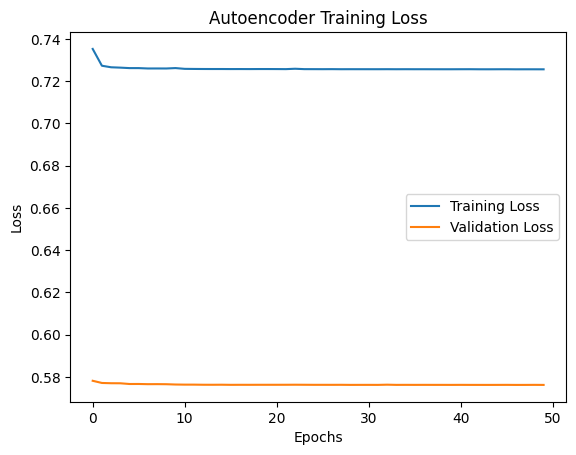

In [34]:
plt.plot(autoencoder.history.history['loss'], label='Training Loss')
plt.plot(autoencoder.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.show()

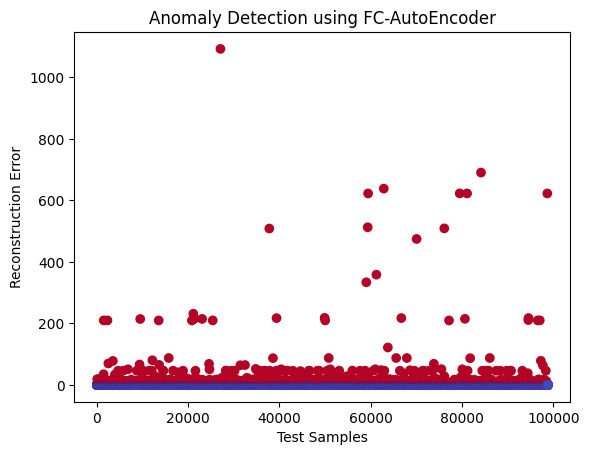

In [35]:
plt.scatter(range(len(reconstruction_error)), reconstruction_error, c=anomalies, cmap='coolwarm')
plt.title('Anomaly Detection using FC-AutoEncoder')
plt.xlabel('Test Samples')
plt.ylabel('Reconstruction Error')
plt.show()

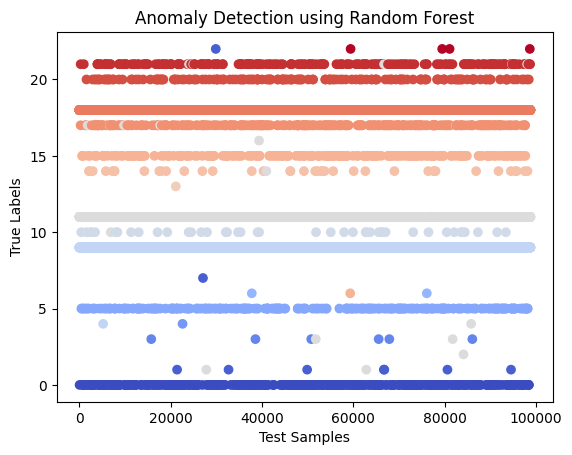

In [36]:
plt.scatter(range(len(y_test)), y_test, c=y_pred_rf, cmap='coolwarm')
plt.title('Anomaly Detection using Random Forest')
plt.xlabel('Test Samples')
plt.ylabel('True Labels')
plt.show()